## 1. Load libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 10000)

In [2]:
from sklearn import datasets
from sklearn import linear_model, ensemble, tree
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import datetime

## 2. Read in results of grid search and hyper parameters tuning

In [3]:
res = pd.read_csv("all_results.csv")

In [4]:
res.model.unique()

array(['Linear', 'Ridge', 'Lasso', 'ElasticNet', 'DecisionTree',
       'RandomForest', 'Boosting'], dtype=object)

In [5]:
for v in ['rank_by_CV_mean_test_rmse', 'CV_mean_train_rmse', 'CV_mean_test_rmse',
         'mean_train_rmse', 'mean_test_rmse']:
    res[v] = res[v].astype(float)

In [6]:
res_no2019 = res[res['Validate Year'] != '[2019]']

In [7]:
res.head(2)

,params,rank_by_CV_mean_test_rmse,CV_mean_train_rmse,CV_mean_test_rmse,mean_train_rmse,mean_test_rmse,Train Years,Validate Year,model
0,{},1.0,115024.277257,9.948330e+15,116783.935319,112808.322608,[2016],[2017],Linear
1,{},1.0,111231.800815,1.802549e+15,112679.638741,123131.266713,"[2016, 2017]",[2018],Linear


## 3. Random Forest performs the best among all the classes of models we tried

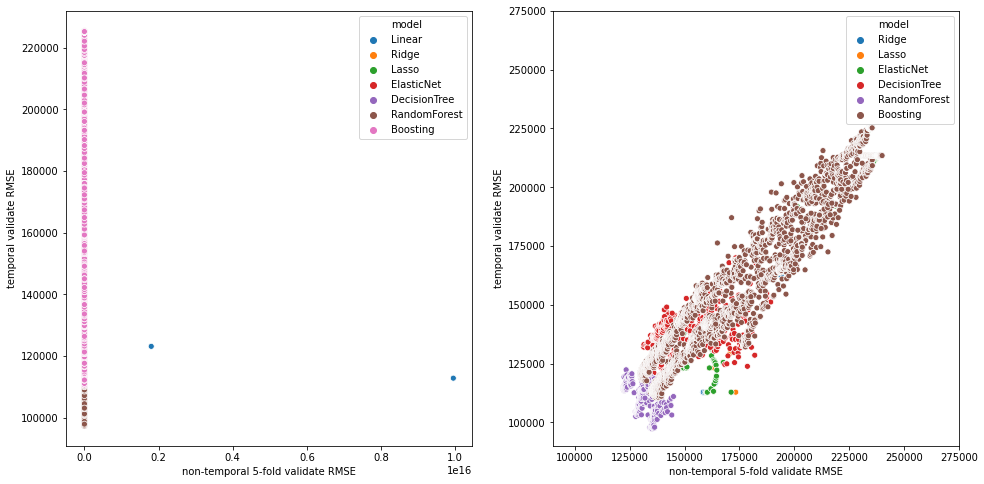

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1 = sns.scatterplot(x="CV_mean_test_rmse", y="mean_test_rmse",
                     hue="model", data=res_no2019, ax=ax1)
ax1.set(xlabel='non-temporal 5-fold validate RMSE', ylabel='temporal validate RMSE')

ax2 = sns.scatterplot(x="CV_mean_test_rmse", y="mean_test_rmse",
                     hue="model", data=res_no2019[res_no2019['model'] != 'Linear'], ax=ax2)
ax2.set(ylim=(90000, 275000), xlim=(90000, 275000))
ax2.set(xlabel='non-temporal 5-fold validate RMSE', ylabel='temporal validate RMSE')
plt.show()

## 4. Choosing the best set (or sets) of hyper parameters for Random Forest

In [9]:
res_rf2017 = res_no2019[(res_no2019['model'] == 'RandomForest') & (res_no2019['Validate Year'] == '[2017]')]
res_rf2017 = res_rf2017.rename(columns={'rank_by_CV_mean_test_rmse': '2017_rank_by_CV_mean_test_rmse',
                                        'CV_mean_train_rmse': '2017_CV_mean_train_rmse',
                                        'CV_mean_test_rmse': '2017_CV_mean_test_rmse',
                                        'mean_train_rmse': '2017_mean_train_rmse',
                                        'mean_test_rmse': '2017_mean_test_rmse'})
res_rf2017 = res_rf2017.drop(columns=['Train Years', 'Validate Year'])

res_rf2018 = res_no2019[(res_no2019['model'] == 'RandomForest') & (res_no2019['Validate Year'] == '[2018]')]
res_rf2018 = res_rf2018.rename(columns={'rank_by_CV_mean_test_rmse': '2018_rank_by_CV_mean_test_rmse',
                                        'CV_mean_train_rmse': '2018_CV_mean_train_rmse',
                                        'CV_mean_test_rmse': '2018_CV_mean_test_rmse',
                                        'mean_train_rmse': '2018_mean_train_rmse',
                                        'mean_test_rmse': '2018_mean_test_rmse'})
res_rf2018 = res_rf2018.drop(columns=['Train Years', 'Validate Year'])

res_rf = res_rf2017.merge(res_rf2018, on=['model', 'params'], how='inner')

res_rf['2017_rank'] = res_rf['2017_mean_test_rmse'].rank()
res_rf['2018_rank'] = res_rf['2018_mean_test_rmse'].rank()
res_rf['2017_2018_rank'] = (res_rf['2017_rank'] + res_rf['2018_rank'])/2

res_rf['2017_test_vs_CV'] = res_rf['2017_mean_test_rmse']/res_rf['2017_CV_mean_test_rmse']
res_rf['2018_test_vs_CV'] = res_rf['2018_mean_test_rmse']/res_rf['2018_CV_mean_test_rmse']
res_rf['2017_CV_vs_min_CV'] = res_rf['2017_CV_mean_test_rmse']/res_rf['2017_CV_mean_test_rmse'].min()
res_rf['2018_CV_vs_min_CV'] = res_rf['2018_CV_mean_test_rmse']/res_rf['2018_CV_mean_test_rmse'].min()

res_rf['max_depth'] = ''
res_rf['max_features'] = ''
res_rf['min_samples_split'] = ''
res_rf['n_estimators'] = ''

for i in range(len(res_rf['params'])):
    p = ast.literal_eval(res_rf['params'].iloc[i])
    res_rf['max_depth'].iloc[i] = p['max_depth']
    res_rf['max_features'].iloc[i] = p['max_features']
    res_rf['min_samples_split'].iloc[i] = p['min_samples_split']
    res_rf['n_estimators'].iloc[i] = p['n_estimators']

In [10]:
res_rf2019 = res[(res['Validate Year'] == '[2019]') & (res['model']=='RandomForest')]
res_rf2019['test_rmse_rank'] = res_rf2019['mean_test_rmse'].rank()

### 4a. Select top 3 sets of hyper parameters based on temporal validate RMSEs

In [11]:
res_rf[['params', '2017_CV_mean_test_rmse', '2018_CV_mean_test_rmse',
        '2017_mean_test_rmse', '2018_mean_test_rmse',
        '2017_rank', '2018_rank', '2017_2018_rank',
        '2017_CV_vs_min_CV', '2018_CV_vs_min_CV']].merge(res_rf2019[['params', 'mean_test_rmse', 'test_rmse_rank']],
         on='params', how='inner').sort_values(by=['2017_2018_rank'])[:3].rename(
    columns={'2017_CV_mean_test_rmse': 'before 2017 5-fold RMSE',
             '2018_CV_mean_test_rmse': 'before 2018 5-fold RMSE',
             '2017_mean_test_rmse': '2017 temporal RMSE',
             '2018_mean_test_rmse': '2018 temporal RMSE',
             '2017_rank': '2017 rank',
             '2018_rank': '2018 rank',
             '2017_2018_rank': 'avg rank',
             'mean_test_rmse': '2019 temporal RMSE',
             'test_rmse_rank': '2019 rank',
             '2017_CV_vs_min_CV': '% diff vs. best 2017 5-fold RMSE',
             '2018_CV_vs_min_CV': '% diff vs. best 2018 5-fold RMSE'})

,params,before 2017 5-fold RMSE,before 2018 5-fold RMSE,2017 temporal RMSE,2018 temporal RMSE,2017 rank,2018 rank,avg rank,% diff vs. best 2017 5-fold RMSE,% diff vs. best 2018 5-fold RMSE,2019 temporal RMSE,2019 rank
78,"{'max_depth': 70, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 500}",134749.297932,129737.650445,97552.599593,108887.766003,3.0,2.0,2.5,1.060948,1.062300,90355.670440,6.0
88,"{'max_depth': 90, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 500}",135182.510934,130178.815129,97286.301670,109221.684971,2.0,7.0,4.5,1.064359,1.065912,90070.947067,4.0
77,"{'max_depth': 40, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 500}",134658.482976,130077.491005,97757.705002,109073.092605,5.0,6.0,5.5,1.060233,1.065083,89959.882884,3.0


### 4b. Sanity checks on hyper parameters

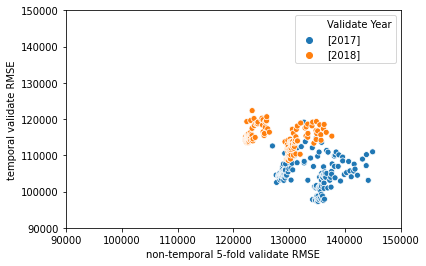

In [12]:
ax = sns.scatterplot(x="CV_mean_test_rmse", y="mean_test_rmse",
                     hue="Validate Year", data=res_no2019[res_no2019['model'] == 'RandomForest'])
ax.set(ylim=(90000, 150000), xlim=(90000, 150000))
ax.set(xlabel='non-temporal 5-fold validate RMSE', ylabel='temporal validate RMSE')
plt.show()

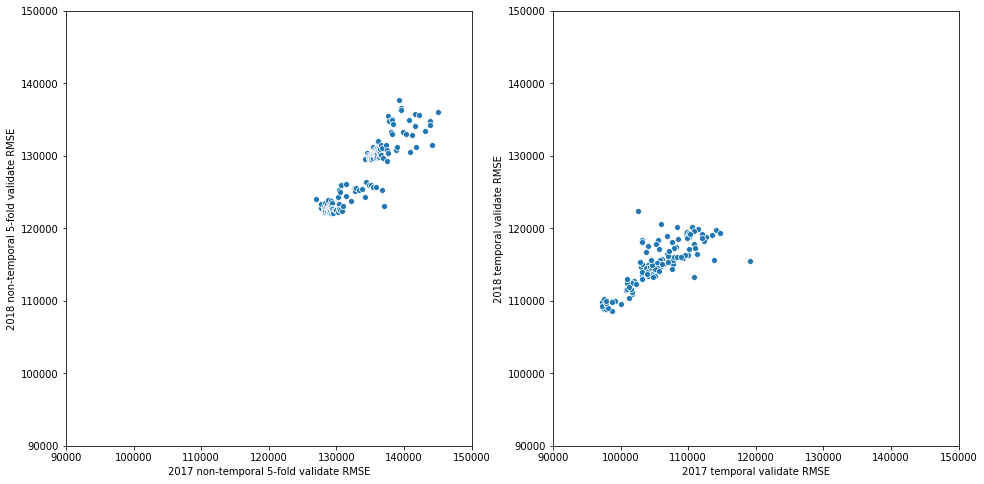

In [13]:
fig, (cv, test) = plt.subplots(1, 2, figsize=(16, 8))

cv = sns.scatterplot(x="2017_CV_mean_test_rmse", y="2018_CV_mean_test_rmse",
                     data=res_rf, ax=cv)
cv.set(ylim=(90000, 150000), xlim=(90000, 150000))
cv.set(xlabel='2017 non-temporal 5-fold validate RMSE', ylabel='2018 non-temporal 5-fold validate RMSE')

test = sns.scatterplot(x="2017_mean_test_rmse", y="2018_mean_test_rmse",
                     data=res_rf, ax=test)
test.set(ylim=(90000, 150000), xlim=(90000, 150000))
test.set(xlabel='2017 temporal validate RMSE', ylabel='2018 temporal validate RMSE')

plt.show()

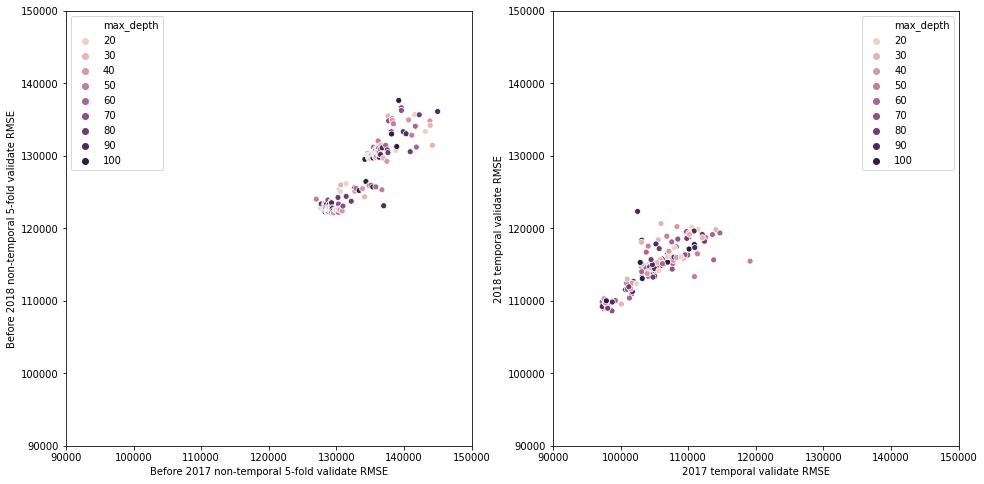

In [14]:
fig, (cv, test) = plt.subplots(1, 2, figsize=(16, 8))

cv = sns.scatterplot(x="2017_CV_mean_test_rmse", y="2018_CV_mean_test_rmse",
                     hue='max_depth', data=res_rf, ax=cv, legend='full')
cv.set(ylim=(90000, 150000), xlim=(90000, 150000))
cv.set(xlabel='Before 2017 non-temporal 5-fold validate RMSE', ylabel='Before 2018 non-temporal 5-fold validate RMSE')

test = sns.scatterplot(x="2017_mean_test_rmse", y="2018_mean_test_rmse",
                     hue='max_depth', data=res_rf, ax=test, legend='full')
test.set(ylim=(90000, 150000), xlim=(90000, 150000))
test.set(xlabel='2017 temporal validate RMSE', ylabel='2018 temporal validate RMSE')

plt.show()

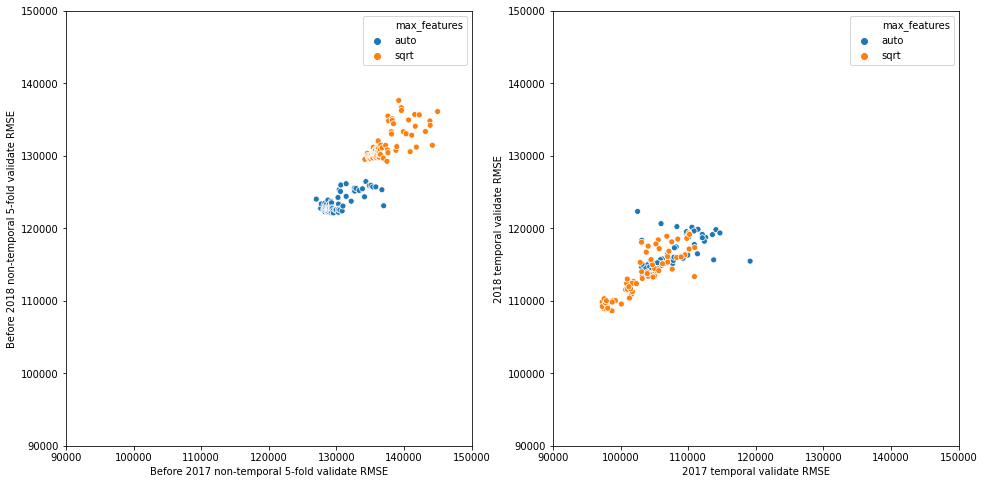

In [15]:
fig, (cv, test) = plt.subplots(1, 2, figsize=(16, 8))

cv = sns.scatterplot(x="2017_CV_mean_test_rmse", y="2018_CV_mean_test_rmse",
                     hue='max_features', data=res_rf, ax=cv)
cv.set(ylim=(90000, 150000), xlim=(90000, 150000))
cv.set(xlabel='Before 2017 non-temporal 5-fold validate RMSE', ylabel='Before 2018 non-temporal 5-fold validate RMSE')

test = sns.scatterplot(x="2017_mean_test_rmse", y="2018_mean_test_rmse",
                     hue='max_features', data=res_rf, ax=test)
test.set(ylim=(90000, 150000), xlim=(90000, 150000))
test.set(xlabel='2017 temporal validate RMSE', ylabel='2018 temporal validate RMSE')

plt.show()

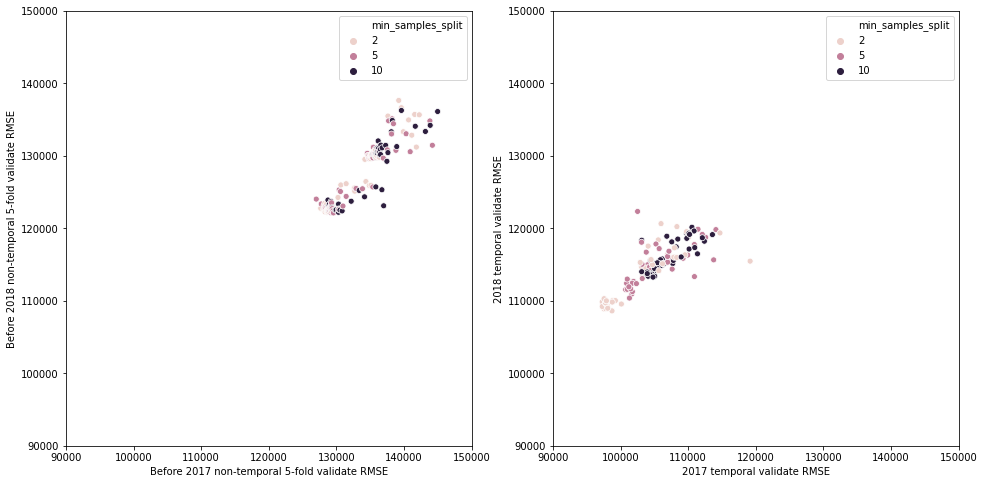

In [16]:
fig, (cv, test) = plt.subplots(1, 2, figsize=(16, 8))

cv = sns.scatterplot(x="2017_CV_mean_test_rmse", y="2018_CV_mean_test_rmse",
                     hue='min_samples_split', data=res_rf, ax=cv, legend='full')
cv.set(ylim=(90000, 150000), xlim=(90000, 150000))
cv.set(xlabel='Before 2017 non-temporal 5-fold validate RMSE', ylabel='Before 2018 non-temporal 5-fold validate RMSE')

test = sns.scatterplot(x="2017_mean_test_rmse", y="2018_mean_test_rmse",
                     hue='min_samples_split', data=res_rf, ax=test, legend='full')
test.set(ylim=(90000, 150000), xlim=(90000, 150000))
test.set(xlabel='2017 temporal validate RMSE', ylabel='2018 temporal validate RMSE')

plt.show()

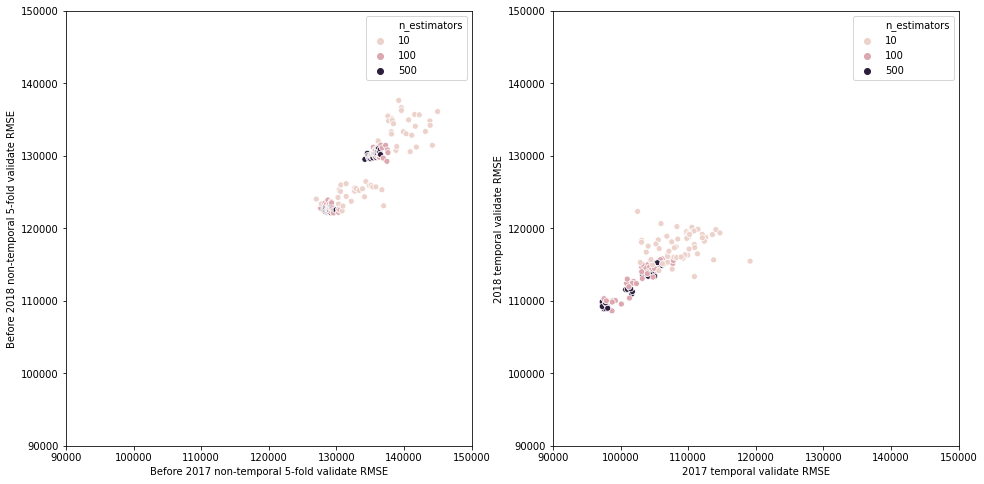

In [17]:
fig, (cv, test) = plt.subplots(1, 2, figsize=(16, 8))

cv = sns.scatterplot(x="2017_CV_mean_test_rmse", y="2018_CV_mean_test_rmse",
                     hue='n_estimators', data=res_rf, ax=cv, legend='full')
cv.set(ylim=(90000, 150000), xlim=(90000, 150000))
cv.set(xlabel='Before 2017 non-temporal 5-fold validate RMSE', ylabel='Before 2018 non-temporal 5-fold validate RMSE')

test = sns.scatterplot(x="2017_mean_test_rmse", y="2018_mean_test_rmse",
                     hue='n_estimators', data=res_rf, ax=test, legend='full')
test.set(ylim=(90000, 150000), xlim=(90000, 150000))
test.set(xlabel='2017 temporal validate RMSE', ylabel='2018 temporal validate RMSE')

plt.show()

## 5. Use the selected models and hyper parameters to predict future values

### 5a. Set up variables and functions

In [18]:
NUM_VARS = ['prev_year_no_of_sales', 'prev_year_avg_age',
       'prev_year_price_p_sf', 'prev_year_price_p_house', 'prev_year_avg_sf',
       'Total Population', 'Median Age', 'Median HH Income',
       'Total Housing Units', 'Median Number of Rooms', 'Median Year Built',
       'Median Gross Rent', 'Mean HH Size', 'Percent White', 'Percent Black',
       'Percent HH with Children', 'Percent Housing Vacant',
       'crime_count', 'crimes_per_capita', 'distance_miles']

CAT_VARS = ['pri_neigh', 'sec_neigh', 'side', 'station_name', 'public_schools']

In [19]:
FEATURES = ['Norm prev_year_no_of_sales',
 'Norm prev_year_avg_age',
 'Norm prev_year_price_p_sf',
 'Norm prev_year_price_p_house',
 'Norm prev_year_avg_sf',
 'Norm Total Population',
 'Norm Median Age',
 'Norm Median HH Income',
 'Norm Total Housing Units',
 'Norm Median Number of Rooms',
 'Norm Median Year Built',
 'Norm Median Gross Rent',
 'Norm Mean HH Size',
 'Norm Percent White',
 'Norm Percent Black',
 'Norm Percent HH with Children',
 'Norm Percent Housing Vacant',
 'Norm crime_count',
 'Norm crimes_per_capita',
 'Norm distance_miles',
 'pri_neigh_Albany Park',
 'pri_neigh_Andersonville',
 'pri_neigh_Archer Heights',
 'pri_neigh_Armour Square',
 'pri_neigh_Ashburn',
 'pri_neigh_Auburn Gresham',
 'pri_neigh_Austin',
 'pri_neigh_Avalon Park',
 'pri_neigh_Avondale',
 'pri_neigh_Belmont Cragin',
 'pri_neigh_Beverly',
 'pri_neigh_Boystown',
 'pri_neigh_Bridgeport',
 'pri_neigh_Brighton Park',
 'pri_neigh_Bucktown',
 'pri_neigh_Burnside',
 'pri_neigh_Calumet Heights',
 'pri_neigh_Chatham',
 'pri_neigh_Chicago Lawn',
 'pri_neigh_Chinatown',
 'pri_neigh_Clearing',
 'pri_neigh_Douglas',
 'pri_neigh_Dunning',
 'pri_neigh_East Side',
 'pri_neigh_East Village',
 'pri_neigh_Edgewater',
 'pri_neigh_Edison Park',
 'pri_neigh_Englewood',
 'pri_neigh_Fuller Park',
 'pri_neigh_Gage Park',
 'pri_neigh_Galewood',
 'pri_neigh_Garfield Park',
 'pri_neigh_Garfield Ridge',
 'pri_neigh_Gold Coast',
 'pri_neigh_Grand Boulevard',
 'pri_neigh_Grand Crossing',
 'pri_neigh_Greektown',
 'pri_neigh_Hegewisch',
 'pri_neigh_Hermosa',
 'pri_neigh_Humboldt Park',
 'pri_neigh_Hyde Park',
 'pri_neigh_Irving Park',
 'pri_neigh_Jefferson Park',
 'pri_neigh_Kenwood',
 'pri_neigh_Lake View',
 'pri_neigh_Lincoln Park',
 'pri_neigh_Lincoln Square',
 'pri_neigh_Little Italy, UIC',
 'pri_neigh_Little Village',
 'pri_neigh_Logan Square',
 'pri_neigh_Loop',
 'pri_neigh_Lower West Side',
 'pri_neigh_Mckinley Park',
 'pri_neigh_Montclare',
 'pri_neigh_Morgan Park',
 'pri_neigh_Mount Greenwood',
 'pri_neigh_Near South Side',
 'pri_neigh_New City',
 'pri_neigh_North Center',
 'pri_neigh_North Lawndale',
 'pri_neigh_North Park',
 'pri_neigh_Norwood Park',
 "pri_neigh_O'Hare",
 'pri_neigh_Oakland',
 'pri_neigh_Old Town',
 'pri_neigh_Portage Park',
 'pri_neigh_Printers Row',
 'pri_neigh_Pullman',
 'pri_neigh_River North',
 'pri_neigh_Riverdale',
 'pri_neigh_Rogers Park',
 'pri_neigh_Roseland',
 'pri_neigh_Rush & Division',
 'pri_neigh_Sauganash,Forest Glen',
 'pri_neigh_Sheffield & DePaul',
 'pri_neigh_South Chicago',
 'pri_neigh_South Deering',
 'pri_neigh_South Shore',
 'pri_neigh_Streeterville',
 'pri_neigh_Ukrainian Village',
 'pri_neigh_United Center',
 'pri_neigh_Uptown',
 'pri_neigh_Washington Heights',
 'pri_neigh_Washington Park',
 'pri_neigh_West Elsdon',
 'pri_neigh_West Lawn',
 'pri_neigh_West Loop',
 'pri_neigh_West Pullman',
 'pri_neigh_West Ridge',
 'pri_neigh_West Town',
 'pri_neigh_Wicker Park',
 'pri_neigh_Woodlawn',
 'pri_neigh_Wrigleyville',
 'side_Central',
 'side_North',
 'side_South',
 'side_West',
 'public_schools_0.0',
 'public_schools_1.0',
 'public_schools_2.0',
 'public_schools_3.0',
 'public_schools_4.0',
 'public_schools_5.0']

TARGETS = 'price_p_house'

In [20]:
def process_bool_and_missing(train, test, features):
    
    for f in features:
        if train[f].dtype == 'bool':
            #print(f, "is bool, converting to int")
            train[f] = train[f].astype(int)
            test[f] = test[f].astype(int)
            
        if train[f].dtype in ('float64', 'int64'):   
            #print(f, "training data's mean:", train[f].mean(),
                #"will replace missing values of", f)
            train[f][train[f].isna()] = train[f].mean()
            test[f][test[f].isna()] = train[f].mean()

    return train, test


def normalize_features(train, test, features):
    
    for feature in features:
        scaler = StandardScaler()
        scaler.fit(pd.DataFrame(train.loc[:, feature]))
        n_feature = 'Norm ' + feature
        train[n_feature] = scaler.transform(pd.DataFrame(train.loc[:, feature]))
        test[n_feature] = scaler.transform(pd.DataFrame(test.loc[:, feature]))

    return train, test


def one_hot_encoding_features(train, test, features, prefix):

    train = pd.get_dummies(train, columns = features, prefix = prefix)
    test = pd.get_dummies(test, columns = features, prefix = prefix)
    
    for v in test.columns:
        if v not in train.columns:
            test = test.drop(columns=[v])
        
    for v in train.columns:
            if v not in test.columns:
                test[v] = 0

    return train, test


def prepare_train_test(train, test, num, cat):

    train, test = process_bool_and_missing(train, test, num)
    train, test = normalize_features(train, test, num)
    train, test = one_hot_encoding_features(train, test, cat, cat)

    return train, test


def temporal_train_test_split(df, train_yr, test_yr, num, cat):
    
    train = df.loc[df.Year.isin(train_yr), :]
    test = df.loc[df.Year.isin(test_yr), :]
    #print('TRAIN: ', train_yr, 'TEST: ', test_yr)
    #print('Training size: ', train.shape) 
    #print('Testing size: ', test.shape) 
    train, test = prepare_train_test(train, test, num, cat)
    
    return train, test

def build_regressors(train, features, targets, model, params):
       
    #print("Training model:", model, "|", params) 
    model.set_params(**params)
    train_features = train[features]
    train_targets = train[targets]
    model.fit(train_features, train_targets)

    return model  

### 5b. Set up selected model and hyper parameters

In [21]:
model_class = ensemble.RandomForestRegressor()
best_params = {'max_depth': 40, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 500}

### 5c. Set up train set (combine target data from 2016-2019, and features data from 2013-2016)

In [22]:
train = pd.read_csv("data/train_data_with_lag.csv")

In [23]:
train['Year'].unique()

array([2016, 2017, 2018, 2019])

In [24]:
train.head(2)

,GEO_ID,Year,pri_neigh,sec_neigh,side,no_of_sales,avg_age,price_p_sf,price_p_house,avg_sf,prev_year_no_of_sales,prev_year_avg_age,prev_year_price_p_sf,prev_year_price_p_house,prev_year_avg_sf,station_name,Total Population,Median Age,Median HH Income,Total Housing Units,Median Number of Rooms,Median Year Built,Median Gross Rent,Mean HH Size,Percent White,Percent Black,Percent HH with Children,Percent Housing Vacant,public_schools,crime_count,crimes_per_capita,distance_miles
0,1500000US170310101001,2016,Rogers Park,ROGERS PARK,North,7,43.142857,335.459870,146857.142857,437.778571,7.0,85.142857,59.796735,204771.428571,3424.458333,Jarvis,526.0,33.8,23032.0,348.0,3.7,1971.0,733.0,1.66,0.444867,0.505703,0.303571,0.091954,0.0,81.0,0.153992,0.1695
1,1500000US170310101001,2017,Rogers Park,ROGERS PARK,North,6,64.666667,108.785979,198000.000000,1820.087500,7.0,55.142857,118.147507,213500.000000,1807.063095,Jarvis,421.0,45.5,14342.0,365.0,3.5,1973.0,733.0,1.38,0.501188,0.453682,0.240000,0.167123,0.0,76.0,0.180523,0.1695


### 5d. Set up test set (features data from 2017-2018)

In [25]:
test = pd.read_csv("data/prediction_data_with_lag.csv")

In [26]:
test.head(2)

,GEO_ID,Year,pri_neigh,sec_neigh,side,no_of_sales,avg_age,price_p_sf,price_p_house,avg_sf,prev_year_no_of_sales,prev_year_avg_age,prev_year_price_p_sf,prev_year_price_p_house,prev_year_avg_sf,station_name,Total Population,Median Age,Median HH Income,Total Housing Units,Median Number of Rooms,Median Year Built,Median Gross Rent,Mean HH Size,Percent White,Percent Black,Percent HH with Children,Percent Housing Vacant,public_schools,crime_count,crimes_per_capita,distance_miles
0,1500000US170310101001,2017,Rogers Park,ROGERS PARK,North,6,64.666667,108.785979,198000.0,1820.0875,6,64.666667,108.785979,198000.0,1820.0875,Jarvis,594.0,47.5,NaN,350.0,4.9,1940.0,784.0,2.09,0.533670,0.303030,0.358974,0.188571,0.0,79.0,0.132997,0.1695
1,1500000US170310101001,2018,Rogers Park,ROGERS PARK,North,5,80.000000,90.469554,235300.0,2600.8750,5,80.000000,90.469554,235300.0,2600.8750,Jarvis,491.0,52.7,NaN,281.0,5.2,NaN,825.0,1.98,0.568228,0.291242,0.306306,0.117438,0.0,49.0,0.099796,0.1695


In [27]:
train, test = prepare_train_test(train, test, NUM_VARS, CAT_VARS)

In [28]:
model = build_regressors(train, FEATURES, TARGETS, model_class, best_params)
model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=40, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [29]:
test_df = test[['GEO_ID', 'Year']]
test_df['Year'] = test_df['Year'] + 3
test_df['predicted_price_p_house'] = model.predict(test[FEATURES])
test_df = test_df.rename(columns={'price_p_house': 'actual_price_p_house'})
test_df.head()

,GEO_ID,Year,predicted_price_p_house
0,1500000US170310101001,2020,255626.750084
1,1500000US170310101001,2021,282565.669237
2,1500000US170310101002,2020,210100.075606
3,1500000US170310101002,2021,212578.750805
4,1500000US170310101003,2020,280106.442050


In [30]:
test_df.to_csv('data/2020_2021_predictions.csv')

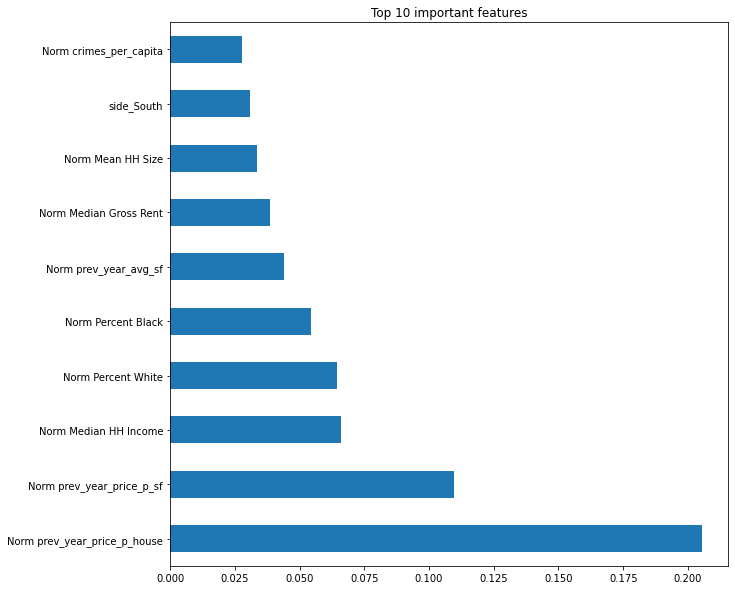

In [31]:
fig = plt.figure(figsize=(10,10))
feat_importances = pd.Series(model.feature_importances_, index=train[FEATURES].columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 important features")
plt.show()